In [3]:
from itertools import groupby
%load_ext autoreload
%autoreload 2

# Analysis of Mock Routing Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from mock_routing_utils import *


In [4]:
a = 10

In [6]:
base_dir = "/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct"
commit = "fc10f2e"

files = find_all_profiling_files(base_dir, commit)
print(f"Found {len(files)} profiling files.")

data = process_all_files(base_dir, commit, num_workers=6)

Found 90 profiling files.
Processing /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-mock_routing2/fc10f2e/routing-profiling-numa2026-01-13_11-49-38.csv
Processing /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-mock_routing2/fc10f2e/routing-profiling-2026-01-13_11-56-17.csv
Processing /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-mock_routing2/fc10f2e/routing-profiling-numa2026-01-13_11-50-46.csv
Processing /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-mock_routing2/fc10f2e/routing-profiling-2026-01-13_11-46-13.csv
Processing /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-mock_routing2/fc10f2e/routing-profiling-numa2026-01-13_11-49-24.csv
Processing /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-mock_routing2/fc10f2e/routing-profiling-nu

Text(0.5, 1.0, 'Time to Complete Routing for 10% of Requests')

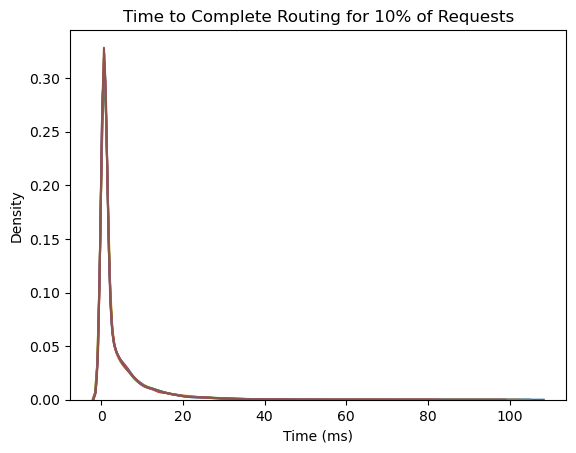

In [18]:
# filter the data for threads = 24 and numa = False. data is a list of dicts whose indices are str
filtered = [d for d in data if d["threads"] == 24 and d["numa"] == False]

# create a kde plot for each value["sample"] in filtered like ...
# sns.kdeplot(data=filtered[0]["sample"]/10e6)
# sns.kdeplot(data=filtered[1]["sample"]/10e6)

for f in filtered:
    sns.kdeplot(data=f["sample"] / 1e6)

# add labels and title
plt.xlabel("Time (ms)")
plt.ylabel("Density")
plt.title("Time to Complete Routing for 10% of Requests")


Text(0.5, 1.0, 'CDF of Time to Complete Routing for 10% of Requests')

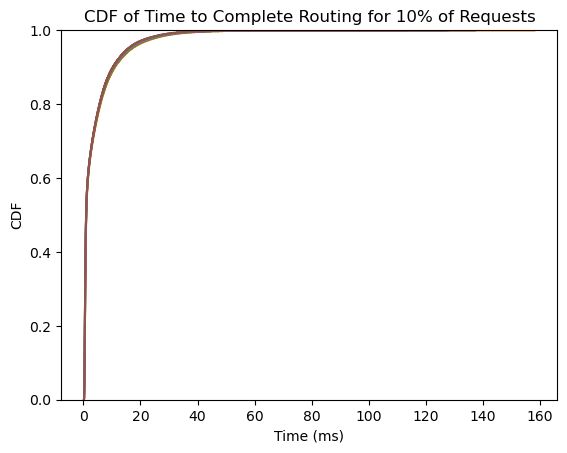

In [12]:
# create cdf plots
for f in filtered:
    sns.ecdfplot(data=f["quantile_values"] / 1e6)

# add labels and title
plt.xlabel("Time (ms)")
plt.ylabel("CDF")
plt.title("CDF of Time to Complete Routing for 10% of Requests")

In [ ]:
# print a table with mean, std, min, max, p50, p95, p99 for each value of filtered
# each value of filtered is a dict that has an entry for each of values of interest
# the output should be in a table format

## Facet plots

Text(0.5, 1.02, 'KDE Plots by Threads and NUMA Configuration (5 Repetitions)')

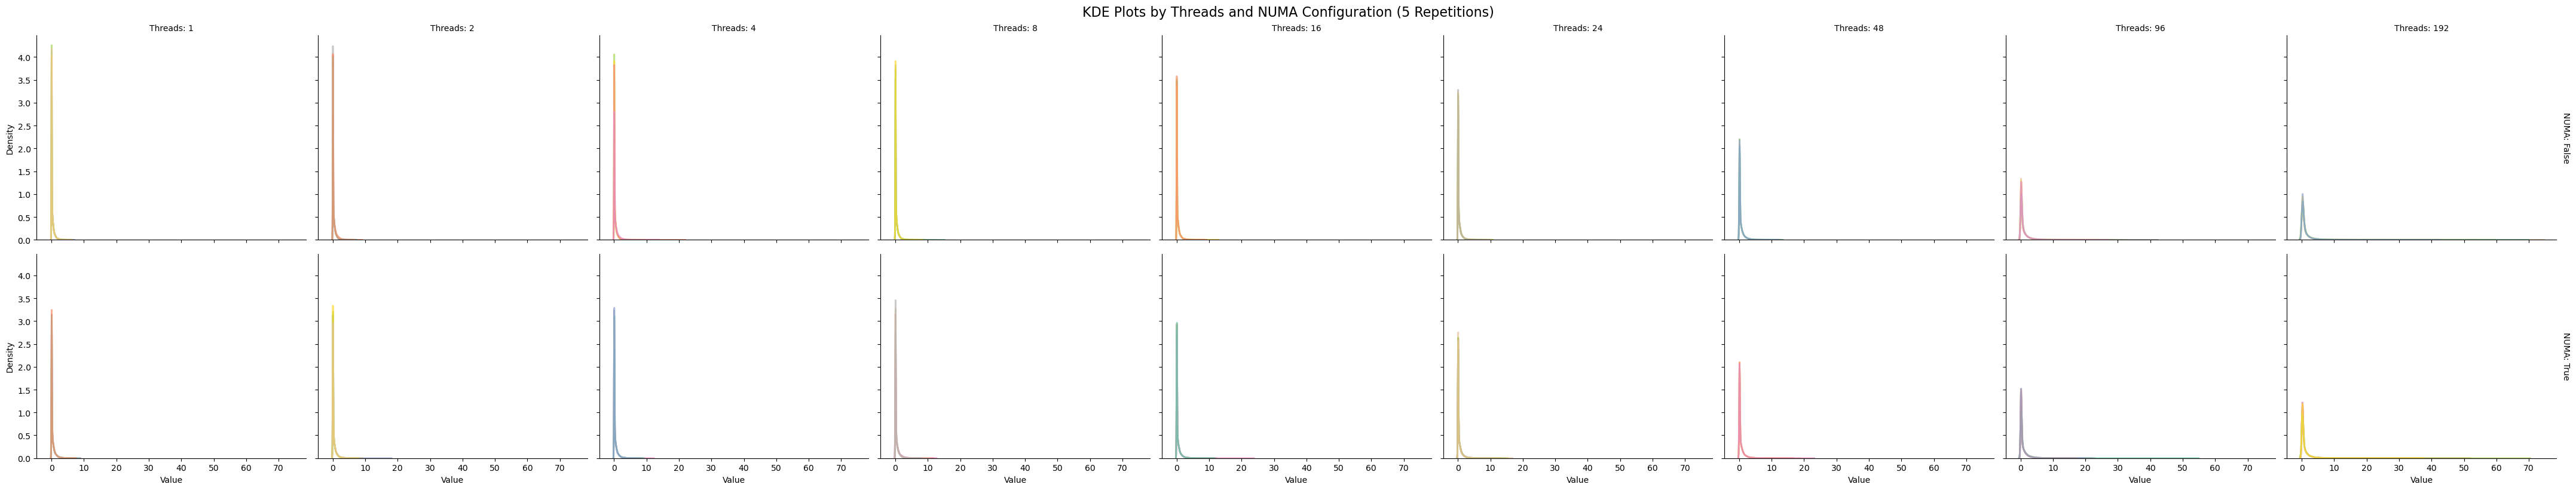

In [13]:
# Convert the list of dicts to a format suitable for plotting
plot_data = []
for idx, d in enumerate(data):
    threads = d['threads']
    numa = d['numa']
    samples = d['sample']

    # Track which repetition this is for this (threads, numa) pair
    rep_id = idx  # or you can calculate it based on grouping

    # Create a row for each sample point
    for value in samples:
        plot_data.append({
            'threads': threads,
            'numa': numa,
            'repetition': rep_id,
            'value': value/1e6  # Convert to ms
        })

df = pd.DataFrame(plot_data)

# Create the facet grid
# You can adjust the faceting variables based on your needs
g = sns.FacetGrid(
    df,
    col='threads',  # One column per thread count
    row='numa',     # One row per numa setting
    hue='repetition',  # Different color for each repetition
    height=4,       # Height of each subplot
    aspect=1.2,     # Aspect ratio
    margin_titles=True,
    palette='Set2'  # Color palette for repetitions
)

# Map the KDE plot to each facet
# Each repetition will be plotted as a separate KDE curve
g.map(sns.kdeplot, 'value', fill=False, alpha=0.7, linewidth=2)

# Customize the plot
g.set_titles(col_template="Threads: {col_name}", row_template="NUMA: {row_name}")
g.set_axis_labels("Value", "Density")
g.fig.suptitle("KDE Plots by Threads and NUMA Configuration (5 Repetitions)", y=1.02, fontsize=16)

# plt.tight_layout()

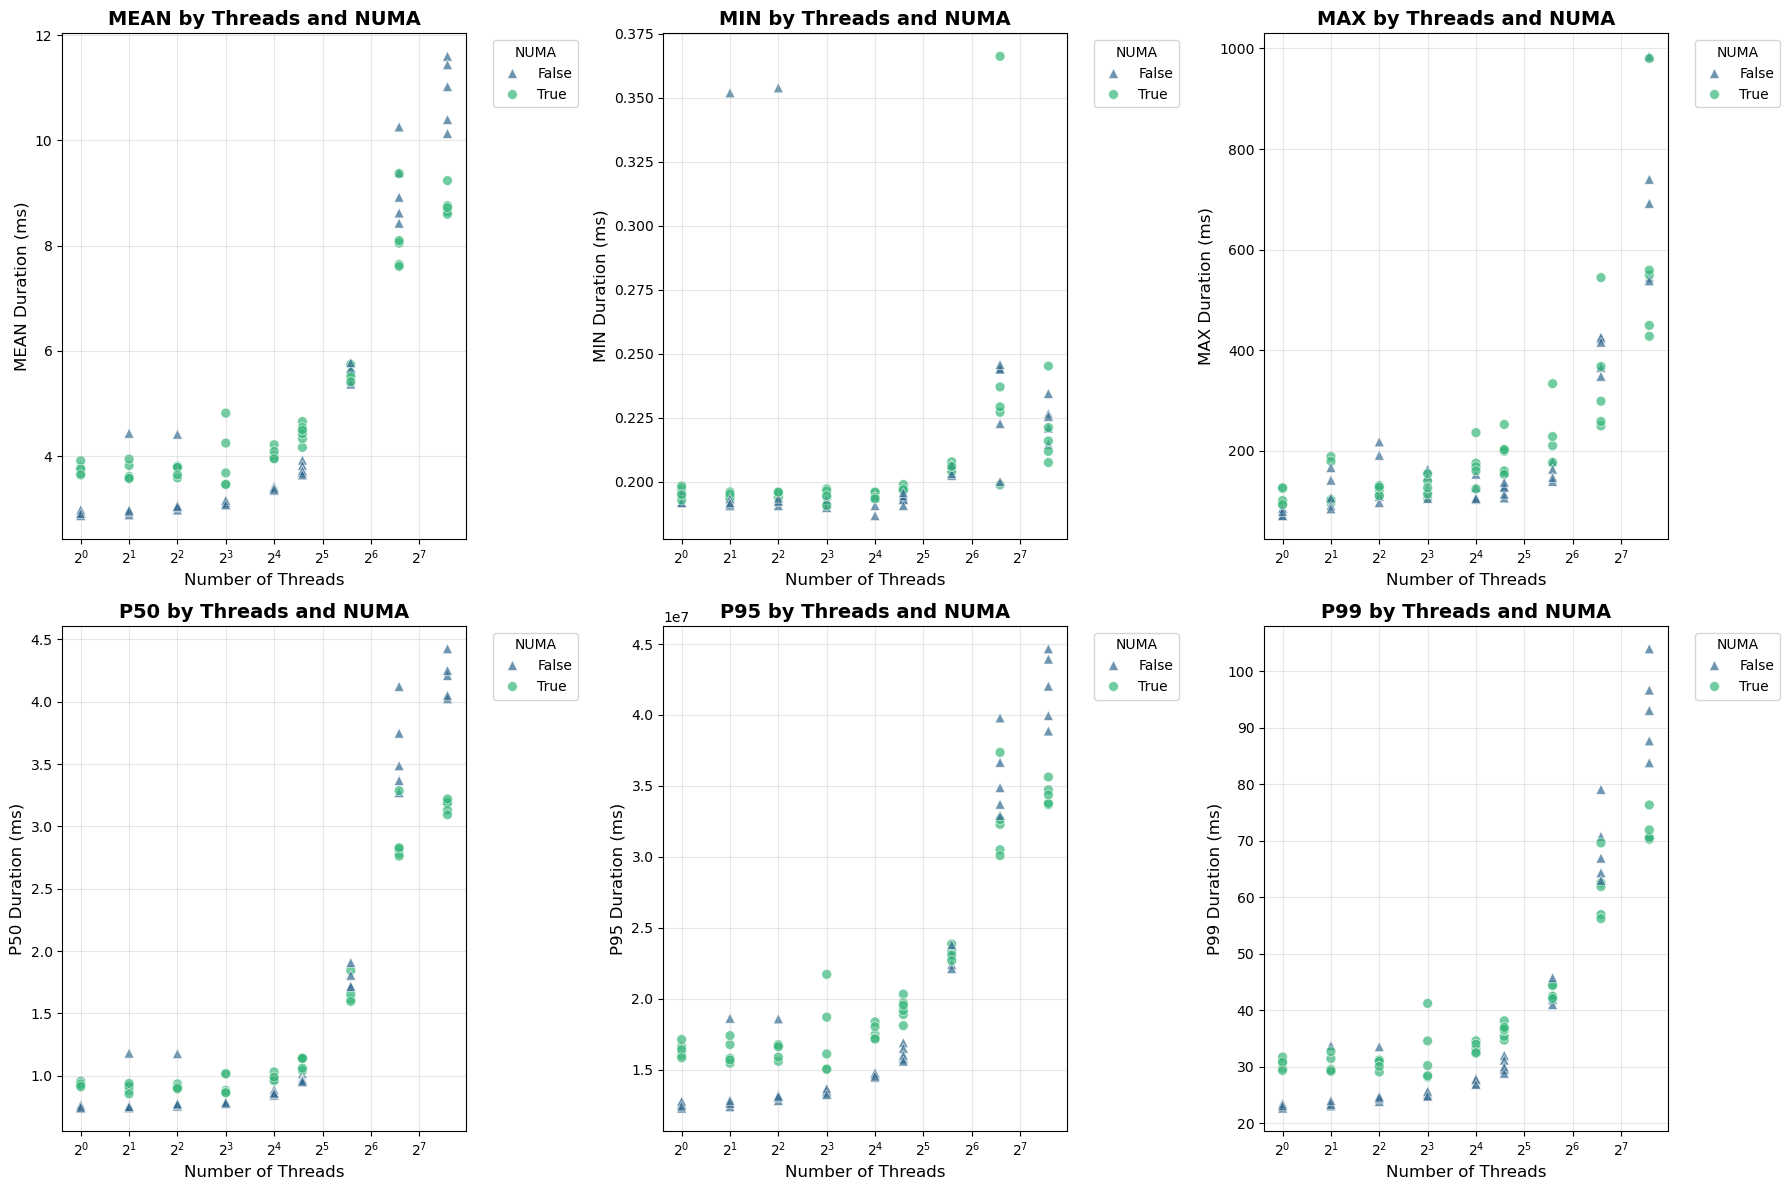

In [30]:
# Convert the list of dicts to a DataFrame
df = pd.DataFrame(data)

# Convert duration values to milliseconds
stats = ['mean', 'min', 'max', 'p50', 'p99']
for stat in stats:
    df[stat] = df[stat] / 1e6

# Statistics to plot
stats = ['mean', 'min', 'max', 'p50', 'p95', 'p99']

# Create a figure with subplots for each statistic
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Get unique NUMA values to determine how many markers we need
numa_values = sorted(df['numa'].unique())

# Define marker styles for different NUMA values (triangles and crosses)
# Only define as many as we need to avoid the warning
markers_available = ['^', 'o']
markers = {numa: markers_available[i % len(markers_available)] for i, numa in enumerate(numa_values)}

for idx, stat in enumerate(stats):
    ax = axes[idx]

    # Create the scatter plot
    sns.scatterplot(
        data=df,
        x='threads',
        y=stat,
        hue='numa',
        style='numa',
        markers=markers,
        s=50,
        alpha=0.7,
        ax=ax,
        palette='viridis'  # Color palette
    )

    # Customize the subplot
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel(f'{stat.upper()} Duration (ms)', fontsize=12)
    ax.set_title(f'{stat.upper()} by Threads and NUMA', fontsize=14, fontweight='bold')
    ax.set_xscale('log', base=2)
    ax.grid(True, alpha=0.3)
    ax.legend(title='NUMA', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()